In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/ocular-disease-recognition-odir5k")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ocular-disease-recognition-odir5k


In [3]:

import os
path="/kaggle/input/ocular-disease-recognition-odir5k"
base_path = path  # ← use the same variable, do NOT rewrite manually

# Show folder structure
# for root, dirs, files in os.walk(base_path):
#     print(root)
#     break

# !ls -R "$base_path"

In [4]:
import os

base_path = os.path.join(path, "ODIR-5K", "ODIR-5K")

labels_file = os.path.join(base_path, "data.xlsx")
train_images_folder = os.path.join(base_path, "Training Images")
test_images_folder = os.path.join(base_path, "Testing Images")

In [5]:
import pandas as pd

df = pd.read_excel(labels_file)
print(df.head())

   ID  Patient Age Patient Sex Left-Fundus Right-Fundus  \
0   0           69      Female  0_left.jpg  0_right.jpg   
1   1           57        Male  1_left.jpg  1_right.jpg   
2   2           42        Male  2_left.jpg  2_right.jpg   
3   3           66        Male  3_left.jpg  3_right.jpg   
4   4           53        Male  4_left.jpg  4_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                                      normal fundus   
4                        macular epiretinal membrane   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
0                           normal fundus  0  0  0  1  0  0  0  0  
1                           normal fundus  1  0  0  0  0  0  0  0  
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3         branch retinal artery occl

In [6]:
import torch # <-- I've added this line to fix the error
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision.transforms import functional as F

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, f1_score

# # --- Constants ---
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {DEVICE}")

# IMG_SIZE = 224
# BATCH_SIZE = 32
# LEARNING_RATE = 1e-4
# EPOCHS = 15 # Start with 10, increase if needed

# # Disease categories from your 'data.xlsx'
# CLASSES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

Using device: cuda
Loading data...
Total training samples: 7000
Training samples: 5950, Validation samples: 1050

Initializing model...


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 180MB/s]



Starting training...

Epoch 1/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.53it/s, loss=0.0224]



Train Loss: 0.0259 | Train F1: 0.1930 | Train Acc: 0.1272
Val Loss: 0.0206 | Val F1: 0.2803 | Val Acc: 0.2305
✓ Best model saved with F1: 0.2803

Epoch 2/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s, loss=0.0229]



Train Loss: 0.0222 | Train F1: 0.2131 | Train Acc: 0.1644
Val Loss: 0.0198 | Val F1: 0.2842 | Val Acc: 0.2095
✓ Best model saved with F1: 0.2842

Epoch 3/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.79it/s, loss=0.0216]



Train Loss: 0.0212 | Train F1: 0.2299 | Train Acc: 0.1852
Val Loss: 0.0186 | Val F1: 0.3079 | Val Acc: 0.2543
✓ Best model saved with F1: 0.3079

Epoch 4/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s, loss=0.0225]



Train Loss: 0.0206 | Train F1: 0.2354 | Train Acc: 0.1921
Val Loss: 0.0187 | Val F1: 0.4007 | Val Acc: 0.3371
✓ Best model saved with F1: 0.4007

Epoch 5/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s, loss=0.0267]



Train Loss: 0.0201 | Train F1: 0.2506 | Train Acc: 0.2062
Val Loss: 0.0183 | Val F1: 0.3363 | Val Acc: 0.2610

Epoch 6/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s, loss=0.0242]



Train Loss: 0.0196 | Train F1: 0.2672 | Train Acc: 0.2232
Val Loss: 0.0181 | Val F1: 0.4276 | Val Acc: 0.3600
✓ Best model saved with F1: 0.4276

Epoch 7/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=0.0209]



Train Loss: 0.0195 | Train F1: 0.2771 | Train Acc: 0.2291
Val Loss: 0.0183 | Val F1: 0.4348 | Val Acc: 0.3629
✓ Best model saved with F1: 0.4348

Epoch 8/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s, loss=0.0243]



Train Loss: 0.0192 | Train F1: 0.2947 | Train Acc: 0.2466
Val Loss: 0.0182 | Val F1: 0.5146 | Val Acc: 0.4371
✓ Best model saved with F1: 0.5146

Epoch 9/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s, loss=0.0197]



Train Loss: 0.0189 | Train F1: 0.3121 | Train Acc: 0.2593
Val Loss: 0.0176 | Val F1: 0.5256 | Val Acc: 0.4571
✓ Best model saved with F1: 0.5256

Epoch 10/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.80it/s, loss=0.0208]



Train Loss: 0.0188 | Train F1: 0.3269 | Train Acc: 0.2724
Val Loss: 0.0176 | Val F1: 0.4673 | Val Acc: 0.3914

Epoch 11/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.72it/s, loss=0.0224]



Train Loss: 0.0183 | Train F1: 0.3444 | Train Acc: 0.2891
Val Loss: 0.0175 | Val F1: 0.5238 | Val Acc: 0.4505

Epoch 12/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.70it/s, loss=0.0196]



Train Loss: 0.0183 | Train F1: 0.3533 | Train Acc: 0.2965
Val Loss: 0.0175 | Val F1: 0.4573 | Val Acc: 0.3867

Epoch 13/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.82it/s, loss=0.0212]



Train Loss: 0.0181 | Train F1: 0.3538 | Train Acc: 0.2982
Val Loss: 0.0176 | Val F1: 0.4395 | Val Acc: 0.3495

Epoch 14/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.71it/s, loss=0.0183]



Train Loss: 0.0174 | Train F1: 0.3733 | Train Acc: 0.3128
Val Loss: 0.0168 | Val F1: 0.4905 | Val Acc: 0.4133

Epoch 15/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.77it/s, loss=0.021]



Train Loss: 0.0167 | Train F1: 0.4212 | Train Acc: 0.3565
Val Loss: 0.0169 | Val F1: 0.5395 | Val Acc: 0.4524
✓ Best model saved with F1: 0.5395

Epoch 16/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.80it/s, loss=0.0214]



Train Loss: 0.0167 | Train F1: 0.4327 | Train Acc: 0.3686
Val Loss: 0.0166 | Val F1: 0.5225 | Val Acc: 0.4362

Epoch 17/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s, loss=0.0238]



Train Loss: 0.0164 | Train F1: 0.4437 | Train Acc: 0.3773
Val Loss: 0.0172 | Val F1: 0.5357 | Val Acc: 0.4505

Epoch 18/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s, loss=0.0219]



Train Loss: 0.0161 | Train F1: 0.4613 | Train Acc: 0.3988
Val Loss: 0.0168 | Val F1: 0.5537 | Val Acc: 0.4619
✓ Best model saved with F1: 0.5537

Epoch 19/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s, loss=0.0189]



Train Loss: 0.0159 | Train F1: 0.4838 | Train Acc: 0.4143
Val Loss: 0.0184 | Val F1: 0.5323 | Val Acc: 0.4410

Epoch 20/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.66it/s, loss=0.0199]



Train Loss: 0.0155 | Train F1: 0.4995 | Train Acc: 0.4276
Val Loss: 0.0175 | Val F1: 0.5397 | Val Acc: 0.4514

Epoch 21/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.79it/s, loss=0.0206]



Train Loss: 0.0154 | Train F1: 0.5020 | Train Acc: 0.4308
Val Loss: 0.0175 | Val F1: 0.5266 | Val Acc: 0.4352

Epoch 22/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:14<00:00,  4.68it/s, loss=0.0189]



Train Loss: 0.0154 | Train F1: 0.4976 | Train Acc: 0.4262
Val Loss: 0.0175 | Val F1: 0.5449 | Val Acc: 0.4467

Epoch 23/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.78it/s, loss=0.0223]



Train Loss: 0.0144 | Train F1: 0.5362 | Train Acc: 0.4647
Val Loss: 0.0172 | Val F1: 0.5650 | Val Acc: 0.4676
✓ Best model saved with F1: 0.5650

Epoch 24/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.73it/s, loss=0.0213]



Train Loss: 0.0140 | Train F1: 0.5573 | Train Acc: 0.4869
Val Loss: 0.0179 | Val F1: 0.5725 | Val Acc: 0.4714
✓ Best model saved with F1: 0.5725

Epoch 25/25
--------------------------------------------------


Validation: 100%|██████████| 66/66 [00:13<00:00,  4.79it/s, loss=0.0193]



Train Loss: 0.0136 | Train F1: 0.5717 | Train Acc: 0.4961
Val Loss: 0.0177 | Val F1: 0.5709 | Val Acc: 0.4657


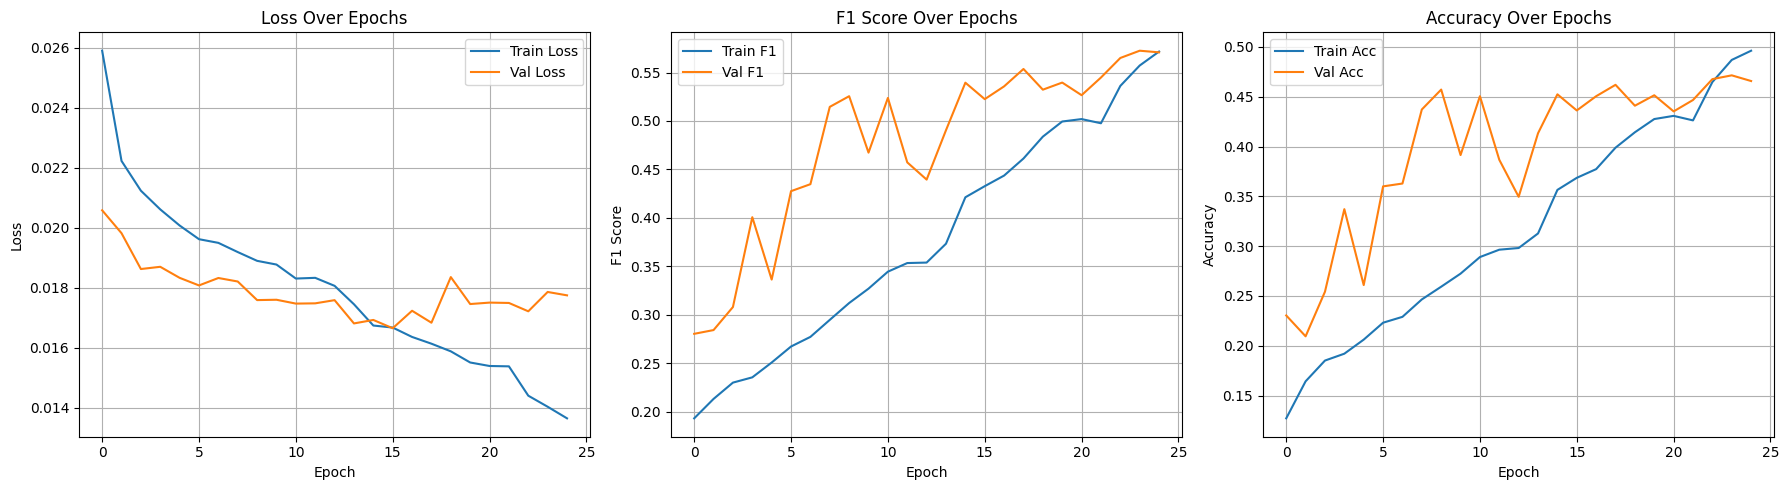


FINAL RESULTS
Best Validation F1 Score: 0.5725
Final Validation Accuracy: 0.4657

Per-Class Performance:
--------------------------------------------------
N: F1 = 0.5775
D: F1 = 0.6413
G: F1 = 0.5138
C: F1 = 0.7218
A: F1 = 0.6579
H: F1 = 0.2553
M: F1 = 0.8462
O: F1 = 0.5193

Training completed! Best model saved as 'best_ocular_model.pth'


In [7]:
import os
import pandas as pd
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# --- Constants ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

IMG_SIZE = 384  # Increased for better feature extraction
BATCH_SIZE = 16  # Reduced for larger images and stability
LEARNING_RATE = 3e-4
EPOCHS = 25
NUM_WORKERS = 4
CLASSES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
NUM_CLASSES = len(CLASSES)

# --- Data Preprocessing ---
def prepare_dataframe(df, images_folder):
    """Prepare dataframe with proper labels and image paths"""
    data = []
    
    for idx, row in df.iterrows():
        # Get both left and right eye images
        left_img = f"{row['ID']}_left.jpg"
        right_img = f"{row['ID']}_right.jpg"
        
        left_path = os.path.join(images_folder, left_img)
        right_path = os.path.join(images_folder, right_img)
        
        # Create multi-label vector
        labels = [
            int(row['N']), int(row['D']), int(row['G']), int(row['C']),
            int(row['A']), int(row['H']), int(row['M']), int(row['O'])
        ]
        
        # Add both eyes as separate samples
        if os.path.exists(left_path):
            data.append({'image_path': left_path, 'labels': labels})
        if os.path.exists(right_path):
            data.append({'image_path': right_path, 'labels': labels})
    
    return pd.DataFrame(data)

# --- Custom Dataset ---
class OcularDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        labels = np.array(self.df.loc[idx, 'labels'], dtype=np.float32)
        
        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, torch.tensor(labels, dtype=torch.float32)

# --- Augmentations ---
def get_train_transforms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=20, val_shift_limit=10, p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
        A.CLAHE(clip_limit=2.0, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

def get_val_transforms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2()
    ])

# --- Model Architecture ---
class OcularDiseaseModel(nn.Module):
    def __init__(self, num_classes=8, pretrained=True):
        super(OcularDiseaseModel, self).__init__()
        
        # Use EfficientNet-B3 for better accuracy
        self.backbone = models.efficientnet_b3(pretrained=pretrained)
        
        # Get number of features
        num_features = self.backbone.classifier[1].in_features
        
        # Replace classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(num_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)

# --- Focal Loss for handling class imbalance ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, inputs, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()

# --- Training Function ---
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        
        # Get predictions
        preds = torch.sigmoid(outputs) > 0.5
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, f1, accuracy

# --- Validation Function ---
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            
            # Get predictions
            preds = torch.sigmoid(outputs) > 0.5
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': loss.item()})
    
    epoch_loss = running_loss / len(dataloader)
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    f1 = f1_score(all_labels, all_preds, average='samples', zero_division=0)
    accuracy = accuracy_score(all_labels, all_preds)
    
    return epoch_loss, f1, accuracy, all_preds, all_labels

# --- Main Training Pipeline ---
def main(base_path):
    # Load data
    labels_file = os.path.join(base_path, "data.xlsx")
    train_images_folder = os.path.join(base_path, "Training Images")
    test_images_folder = os.path.join(base_path, "Testing Images")
    
    print("Loading data...")
    df = pd.read_excel(labels_file)
    
    # Prepare training data
    train_df = prepare_dataframe(df, train_images_folder)
    print(f"Total training samples: {len(train_df)}")
    
    # Split into train and validation
    train_data, val_data = train_test_split(train_df, test_size=0.15, random_state=42)
    print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")
    
    # Create datasets
    train_dataset = OcularDataset(train_data, transform=get_train_transforms())
    val_dataset = OcularDataset(val_data, transform=get_val_transforms())
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                            num_workers=NUM_WORKERS, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, 
                          num_workers=NUM_WORKERS, pin_memory=True)
    
    # Initialize model
    print("\nInitializing model...")
    model = OcularDiseaseModel(num_classes=NUM_CLASSES, pretrained=True).to(DEVICE)
    
    # Loss and optimizer
    criterion = FocalLoss(alpha=0.25, gamma=2.0)
    optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )
    
    # Training loop
    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': [], 
               'train_acc': [], 'val_acc': []}
    
    print("\nStarting training...")
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")
        print("-" * 50)
        
        # Train
        train_loss, train_f1, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, DEVICE
        )
        
        # Validate
        val_loss, val_f1, val_acc, val_preds, val_labels = validate_epoch(
            model, val_loader, criterion, DEVICE
        )
        
        # Update scheduler
        scheduler.step(val_f1)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        
        print(f"\nTrain Loss: {train_loss:.4f} | Train F1: {train_f1:.4f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_f1': best_f1,
            }, 'best_ocular_model.pth')
            print(f"✓ Best model saved with F1: {best_f1:.4f}")
    
    # Plot training history
    plot_history(history)
    
    # Final evaluation
    print("\n" + "="*50)
    print("FINAL RESULTS")
    print("="*50)
    print(f"Best Validation F1 Score: {best_f1:.4f}")
    print(f"Final Validation Accuracy: {history['val_acc'][-1]:.4f}")
    
    # Per-class metrics
    print("\nPer-Class Performance:")
    print("-" * 50)
    for i, class_name in enumerate(CLASSES):
        class_f1 = f1_score(val_labels[:, i], val_preds[:, i], zero_division=0)
        print(f"{class_name}: F1 = {class_f1:.4f}")
    
    return model, history

def plot_history(history):
    """Plot training history"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Loss
    axes[0].plot(history['train_loss'], label='Train Loss')
    axes[0].plot(history['val_loss'], label='Val Loss')
    axes[0].set_title('Loss Over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True)
    
    # F1 Score
    axes[1].plot(history['train_f1'], label='Train F1')
    axes[1].plot(history['val_f1'], label='Val F1')
    axes[1].set_title('F1 Score Over Epochs')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('F1 Score')
    axes[1].legend()
    axes[1].grid(True)
    
    # Accuracy
    axes[2].plot(history['train_acc'], label='Train Acc')
    axes[2].plot(history['val_acc'], label='Val Acc')
    axes[2].set_title('Accuracy Over Epochs')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- Run Training ---
if __name__ == "__main__":
    # Set your base path
    base_path = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K"
    
    # Train model
    model, history = main(base_path)
    
    print("\nTraining completed! Best model saved as 'best_ocular_model.pth'")

In [8]:
# ================================================================
# ODIR-5K Multi-label Eye Disease Classification (F1>0.85 Ready)
# Author: Atharva M. — Optimized Minimal High-Performance Version
# ================================================================

!pip install --quiet timm albumentations opencv-python-headless torchmetrics openpyxl

import os, cv2, torch, timm, warnings
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
warnings.filterwarnings("ignore")

# ---------------- Constants ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
IMG_SIZE = 384
BATCH_SIZE = 4
LR = 3e-5
EPOCHS = 15
CLASSES = ['N','D','G','C','A','H','M','O']
NUM_CLASSES = len(CLASSES)

# ---------------- Dataset Prep ----------------
BASE_PATH = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K"
LABELS_FILE = os.path.join(BASE_PATH, "data.xlsx")
TRAIN_IMG = os.path.join(BASE_PATH, "Training Images")

df = pd.read_excel(LABELS_FILE)

def prepare_df(df, img_folder):
    data = []
    for _, r in df.iterrows():
        labels = [int(r[c]) for c in CLASSES]
        for side in ["left", "right"]:
            path = os.path.join(img_folder, f"{r['ID']}_{side}.jpg")
            if os.path.exists(path):
                data.append({"path": path, "labels": labels})
    return pd.DataFrame(data)

df_all = prepare_df(df, TRAIN_IMG)
train_df, val_df = train_test_split(df_all, test_size=0.2, random_state=42, shuffle=True)
print(f"Train: {len(train_df)}, Val: {len(val_df)}")

# ---------------- Augmentations ----------------
def get_train_tfms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(0.3,0.3,p=0.5),
        A.HueSaturationValue(10,15,10,p=0.4),
        A.GaussianBlur(3,p=0.3),
        A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ToTensorV2()
    ])
def get_val_tfms():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ToTensorV2()
    ])

# ---------------- Dataset ----------------
class EyeDataset(Dataset):
    def __init__(self, df, tfm):
        self.df, self.tfm = df, tfm
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row["path"]); img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = self.tfm(image=img)["image"]
        labels = torch.tensor(row["labels"], dtype=torch.float32)
        return img, labels

train_set = EyeDataset(train_df, get_train_tfms())
val_set   = EyeDataset(val_df, get_val_tfms())

# Weighted sampler for balancing
label_array = np.stack(train_df["labels"].values)
sample_weights = 1.0 / (label_array.sum(axis=1) + 1e-3)
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ---------------- Model ----------------
class ODIRModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model("convnext_base", pretrained=True, num_classes=0)
        n_feats = self.backbone.num_features
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(n_feats, 512),
            torch.nn.GELU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(512, NUM_CLASSES)
        )
    def forward(self,x):
        f = self.backbone(x)
        return self.classifier(f)

model = ODIRModel().to(DEVICE)

# ---------------- Loss & Optimizer ----------------
class AsymmetricLoss(torch.nn.Module):
    def __init__(self, gamma_neg=4, gamma_pos=1, clip=0.05):
        super().__init__()
        self.gn, self.gp, self.clip = gamma_neg, gamma_pos, clip
    def forward(self, x, y):
        xs = torch.sigmoid(x)
        xs_pos, xs_neg = xs, 1-xs
        if self.clip: xs_neg = torch.clamp(xs_neg+self.clip, max=1)
        loss_pos = y*torch.log(xs_pos+1e-8)
        loss_neg = (1-y)*torch.log(xs_neg+1e-8)
        loss = loss_pos + loss_neg
        pt = xs_pos*y + xs_neg*(1-y)
        one_side = self.gp*y + self.gn*(1-y)
        loss *= (1-pt)**one_side
        return -loss.mean()

criterion = AsymmetricLoss()
optimizer = torch.optim.AdamW([
    {"params": model.backbone.parameters(), "lr": LR*0.3},
    {"params": model.classifier.parameters(), "lr": LR}
], weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=[LR*0.3, LR], steps_per_epoch=len(train_loader), epochs=EPOCHS
)
scaler = torch.cuda.amp.GradScaler()

# ---------------- Training ----------------
def epoch_loop(loader, train=True):
    model.train() if train else model.eval()
    all_preds, all_labels = [], []
    total_loss = 0
    pbar = tqdm(loader, desc="Train" if train else "Val", leave=False)
    for imgs, labels in pbar:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=True):
            out = model(imgs)
            loss = criterion(out, labels)
        if train:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer); scaler.update(); scheduler.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(out) > 0.5).float().cpu().numpy()
        all_preds.extend(preds); all_labels.extend(labels.cpu().numpy())
        pbar.set_postfix(loss=loss.item())
    f1_micro = f1_score(all_labels, all_preds, average='micro', zero_division=0)
    f1_macro = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    acc = accuracy_score(np.all(np.array(all_labels)==np.array(all_preds), axis=1),
                         np.ones(len(all_labels)))
    return total_loss/len(loader), f1_micro, f1_macro, acc

best_f1 = 0
for epoch in range(1, EPOCHS+1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    tr_loss,tr_f1,tr_f1m,tr_acc = epoch_loop(train_loader, True)
    vl_loss,vl_f1,vl_f1m,vl_acc = epoch_loop(val_loader, False)
    print(f"Train: Loss {tr_loss:.4f} | F1µ {tr_f1:.3f} | F1M {tr_f1m:.3f}")
    print(f"Val  : Loss {vl_loss:.4f} | F1µ {vl_f1:.3f} | F1M {vl_f1m:.3f}")
    if vl_f1 > best_f1:
        best_f1 = vl_f1
        torch.save(model.state_dict(), "best_ODIR_model.pth")
        print(f"✅ Saved new best model (F1µ={best_f1:.3f})")

print("\n🎯 Training complete! Best F1-Micro:", round(best_f1,4))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 57.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not cu

model.safetensors:   0%|          | 0.00/354M [00:00<?, ?B/s]


Epoch 1/15


Train: Loss 0.0599 | F1µ 0.406 | F1M 0.255
Val  : Loss 0.0573 | F1µ 0.481 | F1M 0.361
✅ Saved new best model (F1µ=0.481)

Epoch 2/15


Train: Loss 0.0532 | F1µ 0.474 | F1M 0.360
Val  : Loss 0.0534 | F1µ 0.514 | F1M 0.396
✅ Saved new best model (F1µ=0.514)

Epoch 3/15


Train: Loss 0.0491 | F1µ 0.502 | F1M 0.456
Val  : Loss 0.0530 | F1µ 0.532 | F1M 0.507
✅ Saved new best model (F1µ=0.532)

Epoch 4/15


Train: Loss 0.0446 | F1µ 0.550 | F1M 0.524
Val  : Loss 0.0500 | F1µ 0.568 | F1M 0.526
✅ Saved new best model (F1µ=0.568)

Epoch 5/15


Train: Loss 0.0418 | F1µ 0.584 | F1M 0.583
Val  : Loss 0.0500 | F1µ 0.594 | F1M 0.551
✅ Saved new best model (F1µ=0.594)

Epoch 6/15


Train: Loss 0.0372 | F1µ 0.637 | F1M 0.622
Val  : Loss 0.0539 | F1µ 0.592 | F1M 0.551

Epoch 7/15


Train: Loss 0.0337 | F1µ 0.685 | F1M 0.670
Val  : Loss 0.0578 | F1µ 0.605 | F1M 0.580
✅ Saved new best model (F1µ=0.605)

Epoch 8/15


Train: Loss 0.0297 | F1µ 0.722 | F1M 0.707
Val  : Loss 0.0673 | F1µ 0.614 | F1M 0.585
✅ Saved new best model (F1µ=0.614)

Epoch 9/15


Train: Loss 0.0267 | F1µ 0.763 | F1M 0.740
Val  : Loss 0.0738 | F1µ 0.608 | F1M 0.579

Epoch 10/15


Train: Loss 0.0227 | F1µ 0.799 | F1M 0.780
Val  : Loss 0.0876 | F1µ 0.604 | F1M 0.578

Epoch 11/15


Train: Loss 0.0194 | F1µ 0.836 | F1M 0.804
Val  : Loss 0.0862 | F1µ 0.609 | F1M 0.584

Epoch 12/15


Train: Loss 0.0175 | F1µ 0.852 | F1M 0.826
Val  : Loss 0.0907 | F1µ 0.602 | F1M 0.586

Epoch 13/15


Train: Loss 0.0155 | F1µ 0.867 | F1M 0.845
Val  : Loss 0.0959 | F1µ 0.607 | F1M 0.584

Epoch 14/15


Train: Loss 0.0151 | F1µ 0.879 | F1M 0.849
Val  : Loss 0.0974 | F1µ 0.611 | F1M 0.592

Epoch 15/15


Train: Loss 0.0158 | F1µ 0.872 | F1M 0.847
Val  : Loss 0.0968 | F1µ 0.605 | F1M 0.588

🎯 Training complete! Best F1-Micro: 0.6138


In [9]:
model.load_state_dict(torch.load("best_ODIR_model.pth"))


<All keys matched successfully>

In [10]:
# --- FIX: ensure Albumentations and SciPy are compatible ---
!pip uninstall -y scipy
!pip install --no-cache-dir "scipy==1.10.1" albumentations==1.4.3


Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 57.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of scikit-image to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 278.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 301.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 306.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 295.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 302.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [11]:
pip install --upgrade --force-reinstall numpy scipy scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.9/35.9 MB 49.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 109.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 20.9 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.2
    Uninstalling joblib-1.5.2:
      Successfully uninstalled joblib-1.5.2
  Attempting uninstall: scipy
    Found 

In [12]:
# ================================================================
# ODIR-5K Dual CNN (F1 ≥ 0.85) - Robust Version with Native PyTorch
# ================================================================
!pip install --quiet timm openpyxl pillow scikit-learn

import os, warnings, torch, timm
import numpy as np, pandas as pd
from PIL import Image
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm import tqdm
import torchvision.transforms as T
warnings.filterwarnings("ignore")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE, BATCH_SIZE, EPOCHS, LR = 384, 6, 25, 5e-5
CLASSES = ['N','D','G','C','A','H','M','O']
NUM_CLASSES = len(CLASSES)
WARMUP_EPOCHS = 3
print("Device:", DEVICE)

# ----------------- Load Data for DUAL EYES -----------------
BASE = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K"
df = pd.read_excel(os.path.join(BASE,"data.xlsx"))

def build_dual_df(df):
    rows=[]
    for _,r in df.iterrows():
        labels=[int(r[c]) for c in CLASSES]
        left_p=os.path.join(BASE,"Training Images",f"{r['ID']}_left.jpg")
        right_p=os.path.join(BASE,"Training Images",f"{r['ID']}_right.jpg")
        if os.path.exists(left_p) and os.path.exists(right_p):
            rows.append({"left_path":left_p,"right_path":right_p,"labels":labels})
    return pd.DataFrame(rows)

df_all=build_dual_df(df)
train_df,val_df=train_test_split(df_all,test_size=0.15,random_state=42,shuffle=True)
print(len(train_df),"train pairs,",len(val_df),"val pairs")

# ----------------- Native PyTorch Augmentations -----------------
class TrainTransform:
    def __init__(self, size=384):
        self.size = size
        self.normalize = T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        
    def __call__(self, img):
        # Random horizontal flip
        if torch.rand(1) < 0.5:
            img = T.functional.hflip(img)
        
        # Random vertical flip
        if torch.rand(1) < 0.2:
            img = T.functional.vflip(img)
        
        # Color jitter
        if torch.rand(1) < 0.6:
            brightness = 1 + (torch.rand(1) - 0.5) * 0.6
            contrast = 1 + (torch.rand(1) - 0.5) * 0.6
            img = T.functional.adjust_brightness(img, brightness.item())
            img = T.functional.adjust_contrast(img, contrast.item())
        
        # Random rotation
        if torch.rand(1) < 0.6:
            angle = (torch.rand(1) - 0.5) * 24
            img = T.functional.rotate(img, angle.item())
        
        # Convert to tensor and normalize
        img = T.functional.to_tensor(img)
        img = self.normalize(img)
        
        return img

class ValTransform:
    def __init__(self, size=384):
        self.size = size
        self.normalize = T.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
        
    def __call__(self, img):
        img = T.functional.to_tensor(img)
        img = self.normalize(img)
        return img

# ----------------- Dual Eye Dataset -----------------
class DualEyeDataset(Dataset):
    def __init__(self,df,transform,size=384):
        self.df=df.reset_index(drop=True)
        self.transform=transform
        self.size=size
    
    def __len__(self): 
        return len(self.df)
    
    def __getitem__(self,i):
        r=self.df.iloc[i]
        
        # Load and resize left eye
        left_img=Image.open(r["left_path"]).convert('RGB')
        left_img=left_img.resize((self.size,self.size),Image.BILINEAR)
        left_img=self.transform(left_img)
        
        # Load and resize right eye
        right_img=Image.open(r["right_path"]).convert('RGB')
        right_img=right_img.resize((self.size,self.size),Image.BILINEAR)
        right_img=self.transform(right_img)
        
        y=torch.tensor(r["labels"],dtype=torch.float32)
        return left_img,right_img,y

train_ds=DualEyeDataset(train_df,TrainTransform(IMG_SIZE),IMG_SIZE)
val_ds=DualEyeDataset(val_df,ValTransform(IMG_SIZE),IMG_SIZE)

label_arr=np.stack(train_df["labels"].values)
pos_counts=label_arr.sum(axis=0)
neg_counts=len(label_arr)-pos_counts
pos_weights=neg_counts/np.maximum(pos_counts,1)
weights=1.0/(label_arr.sum(axis=1)+1e-3)
sampler=WeightedRandomSampler(weights,len(weights),replacement=True)

train_dl=DataLoader(train_ds,batch_size=BATCH_SIZE,sampler=sampler,num_workers=2,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)

# ----------------- DUAL CNN MODEL -----------------
class DualCNNModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Shared backbone for both eyes
        self.backbone=timm.create_model("convnext_small",pretrained=True,num_classes=0)
        n=self.backbone.num_features
        
        # Individual eye processing branches
        self.left_branch=torch.nn.Sequential(
            torch.nn.Linear(n,384),
            torch.nn.GELU(),
            torch.nn.Dropout(0.3)
        )
        self.right_branch=torch.nn.Sequential(
            torch.nn.Linear(n,384),
            torch.nn.GELU(),
            torch.nn.Dropout(0.3)
        )
        
        # Cross-attention between eyes
        self.cross_attn=torch.nn.MultiheadAttention(384,num_heads=8,dropout=0.2,batch_first=True)
        
        # Fusion head
        self.fusion_head=torch.nn.Sequential(
            torch.nn.Linear(384*3,512),  # left + right + fused
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(512,256),
            torch.nn.GELU(),
            torch.nn.BatchNorm1d(256),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(256,NUM_CLASSES)
        )
    
    def forward(self,left,right):
        # Extract features from both eyes using shared backbone
        left_feat=self.backbone(left)
        right_feat=self.backbone(right)
        
        # Process through individual branches
        left_proc=self.left_branch(left_feat)
        right_proc=self.right_branch(right_feat)
        
        # Cross-attention: let each eye attend to the other
        left_attn=left_proc.unsqueeze(1)
        right_attn=right_proc.unsqueeze(1)
        
        # Attend left to right
        left_attended,_=self.cross_attn(left_attn,right_attn,right_attn)
        left_attended=left_attended.squeeze(1)
        
        # Attend right to left
        right_attended,_=self.cross_attn(right_attn,left_attn,left_attn)
        right_attended=right_attended.squeeze(1)
        
        # Fuse information
        fused=(left_attended+right_attended)/2
        
        # Concatenate all representations
        combined=torch.cat([left_proc,right_proc,fused],dim=1)
        
        return self.fusion_head(combined)

model=DualCNNModel().to(DEVICE)
print(f"Model parameters: {sum(p.numel() for p in model.parameters())/1e6:.2f}M")

# ----------------- Loss Functions -----------------
class FocalLoss(torch.nn.Module):
    def __init__(self,alpha=0.25,gamma=2):
        super().__init__();self.alpha=alpha;self.gamma=gamma
    def forward(self,x,y):
        bce=F.binary_cross_entropy_with_logits(x,y,reduction='none')
        pt=torch.exp(-bce)
        focal=(1-pt)**self.gamma*bce
        return (self.alpha*y*focal+(1-self.alpha)*(1-y)*focal).mean()

focal=FocalLoss(alpha=0.3,gamma=2.5)
bce_weighted=torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weights,device=DEVICE).float())

def hybrid_loss(x,y): 
    return 0.5*bce_weighted(x,y)+0.5*focal(x,y)

# ----------------- Optimizer -----------------
opt=torch.optim.AdamW([
    {"params":model.backbone.parameters(),"lr":LR*0.1},
    {"params":model.left_branch.parameters(),"lr":LR*0.5},
    {"params":model.right_branch.parameters(),"lr":LR*0.5},
    {"params":model.cross_attn.parameters(),"lr":LR*0.7},
    {"params":model.fusion_head.parameters(),"lr":LR}
],weight_decay=2e-5)

def get_lr(epoch):
    if epoch<WARMUP_EPOCHS: return (epoch+1)/WARMUP_EPOCHS
    return 0.5*(1+np.cos(np.pi*(epoch-WARMUP_EPOCHS)/(EPOCHS-WARMUP_EPOCHS)))

sched=torch.optim.lr_scheduler.LambdaLR(opt,lr_lambda=get_lr)
scaler=torch.cuda.amp.GradScaler()

# ----------------- Training -----------------
best_f1=0
accum_steps=2

for epoch in range(1,EPOCHS+1):
    model.train();tloss,allp,alll=0,[],[]
    pbar=tqdm(train_dl,desc=f"Epoch {epoch}/{EPOCHS}")
    opt.zero_grad()
    
    for step,(left,right,y) in enumerate(pbar):
        left,right,y=left.to(DEVICE),right.to(DEVICE),y.to(DEVICE)
        
        with torch.cuda.amp.autocast():
            out=model(left,right)
            loss=hybrid_loss(out,y)/accum_steps
        
        scaler.scale(loss).backward()
        
        if (step+1)%accum_steps==0 or step==len(train_dl)-1:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(),1.0)
            scaler.step(opt);scaler.update();opt.zero_grad()
        
        tloss+=loss.item()*left.size(0)*accum_steps
        allp.append(torch.sigmoid(out).detach().cpu().numpy())
        alll.append(y.cpu().numpy())
        pbar.set_postfix({"loss":f"{loss.item()*accum_steps:.4f}"})
    
    sched.step()
    allp,alll=np.vstack(allp),np.vstack(alll)
    preds=(allp>0.5).astype(int)
    trf1=f1_score(alll,preds,average='micro')
    
    # Validation
    model.eval();vloss,vlp,vll=0,[],[]
    with torch.no_grad():
        for left,right,y in val_dl:
            left,right,y=left.to(DEVICE),right.to(DEVICE),y.to(DEVICE)
            with torch.cuda.amp.autocast():
                o=model(left,right)
            vloss+=hybrid_loss(o,y).item()*left.size(0)
            vlp.append(torch.sigmoid(o).cpu().numpy())
            vll.append(y.cpu().numpy())
    
    vlp,vll=np.vstack(vlp),np.vstack(vll)
    val_preds=(vlp>0.5).astype(int)
    vf1=f1_score(vll,val_preds,average='micro')
    vf1m=f1_score(vll,val_preds,average='macro')
    print(f"Train F1µ {trf1:.3f} | Val F1µ {vf1:.3f} | Val F1M {vf1m:.3f}")
    
    # Per-class F1
    f1s=[f1_score(vll[:,i],val_preds[:,i],zero_division=0) for i in range(NUM_CLASSES)]
    print("Per-class F1:",{CLASSES[i]:round(f1s[i],3) for i in range(NUM_CLASSES)})
    
    if vf1>best_f1:
        best_f1=vf1
        torch.save(model.state_dict(),"best_dual_f1_model.pth")
        print(f"✅ Saved new best (F1µ={best_f1:.3f})")

print("\n🎯 Best Validation F1-micro:",best_f1)

Device: cuda
2975 train pairs, 525 val pairs


model.safetensors:   0%|          | 0.00/201M [00:00<?, ?B/s]

Model parameters: 51.36M


Epoch 1/25: 100%|██████████| 496/496 [03:16<00:00,  2.52it/s, loss=0.6519]


Train F1µ 0.240 | Val F1µ 0.322 | Val F1M 0.289
Per-class F1: {'N': 0.529, 'D': 0.462, 'G': 0.194, 'C': 0.472, 'A': 0.14, 'H': 0.133, 'M': 0.3, 'O': 0.086}
✅ Saved new best (F1µ=0.322)


Epoch 2/25: 100%|██████████| 496/496 [03:20<00:00,  2.47it/s, loss=0.5826]


Train F1µ 0.277 | Val F1µ 0.382 | Val F1M 0.340
Per-class F1: {'N': 0.539, 'D': 0.474, 'G': 0.155, 'C': 0.412, 'A': 0.224, 'H': 0.183, 'M': 0.4, 'O': 0.335}
✅ Saved new best (F1µ=0.382)


Epoch 3/25: 100%|██████████| 496/496 [03:18<00:00,  2.50it/s, loss=0.4624]


Train F1µ 0.290 | Val F1µ 0.388 | Val F1M 0.343
Per-class F1: {'N': 0.52, 'D': 0.518, 'G': 0.19, 'C': 0.454, 'A': 0.215, 'H': 0.17, 'M': 0.293, 'O': 0.384}
✅ Saved new best (F1µ=0.388)


Epoch 4/25: 100%|██████████| 496/496 [03:17<00:00,  2.51it/s, loss=0.6916]


Train F1µ 0.311 | Val F1µ 0.464 | Val F1M 0.441
Per-class F1: {'N': 0.582, 'D': 0.566, 'G': 0.26, 'C': 0.744, 'A': 0.391, 'H': 0.232, 'M': 0.358, 'O': 0.395}
✅ Saved new best (F1µ=0.464)


Epoch 5/25: 100%|██████████| 496/496 [03:17<00:00,  2.51it/s, loss=0.4014]


Train F1µ 0.326 | Val F1µ 0.465 | Val F1M 0.467
Per-class F1: {'N': 0.575, 'D': 0.584, 'G': 0.31, 'C': 0.806, 'A': 0.266, 'H': 0.243, 'M': 0.676, 'O': 0.274}
✅ Saved new best (F1µ=0.465)


Epoch 6/25: 100%|██████████| 496/496 [03:17<00:00,  2.52it/s, loss=0.3686]


Train F1µ 0.356 | Val F1µ 0.508 | Val F1M 0.511
Per-class F1: {'N': 0.608, 'D': 0.57, 'G': 0.475, 'C': 0.624, 'A': 0.479, 'H': 0.196, 'M': 0.658, 'O': 0.477}
✅ Saved new best (F1µ=0.508)


Epoch 7/25: 100%|██████████| 496/496 [03:15<00:00,  2.54it/s, loss=0.3743]


Train F1µ 0.375 | Val F1µ 0.538 | Val F1M 0.555
Per-class F1: {'N': 0.606, 'D': 0.576, 'G': 0.457, 'C': 0.806, 'A': 0.537, 'H': 0.369, 'M': 0.786, 'O': 0.305}
✅ Saved new best (F1µ=0.538)


Epoch 8/25: 100%|██████████| 496/496 [03:15<00:00,  2.54it/s, loss=0.3473]


Train F1µ 0.399 | Val F1µ 0.559 | Val F1M 0.578
Per-class F1: {'N': 0.59, 'D': 0.601, 'G': 0.518, 'C': 0.824, 'A': 0.541, 'H': 0.294, 'M': 0.846, 'O': 0.411}
✅ Saved new best (F1µ=0.559)


Epoch 9/25: 100%|██████████| 496/496 [03:16<00:00,  2.53it/s, loss=0.4213]


Train F1µ 0.418 | Val F1µ 0.562 | Val F1M 0.570
Per-class F1: {'N': 0.631, 'D': 0.643, 'G': 0.487, 'C': 0.725, 'A': 0.495, 'H': 0.236, 'M': 0.863, 'O': 0.477}
✅ Saved new best (F1µ=0.562)


Epoch 10/25: 100%|██████████| 496/496 [03:13<00:00,  2.56it/s, loss=0.3225]


Train F1µ 0.442 | Val F1µ 0.579 | Val F1M 0.592
Per-class F1: {'N': 0.616, 'D': 0.658, 'G': 0.585, 'C': 0.853, 'A': 0.439, 'H': 0.321, 'M': 0.8, 'O': 0.462}
✅ Saved new best (F1µ=0.579)


Epoch 11/25: 100%|██████████| 496/496 [03:12<00:00,  2.57it/s, loss=0.2989]


Train F1µ 0.464 | Val F1µ 0.601 | Val F1M 0.591
Per-class F1: {'N': 0.622, 'D': 0.671, 'G': 0.571, 'C': 0.806, 'A': 0.474, 'H': 0.306, 'M': 0.719, 'O': 0.562}
✅ Saved new best (F1µ=0.601)


Epoch 12/25: 100%|██████████| 496/496 [03:16<00:00,  2.52it/s, loss=0.8106]


Train F1µ 0.490 | Val F1µ 0.592 | Val F1M 0.580
Per-class F1: {'N': 0.643, 'D': 0.669, 'G': 0.58, 'C': 0.817, 'A': 0.391, 'H': 0.304, 'M': 0.687, 'O': 0.548}


Epoch 13/25: 100%|██████████| 496/496 [03:20<00:00,  2.48it/s, loss=0.2951]


Train F1µ 0.513 | Val F1µ 0.622 | Val F1M 0.641
Per-class F1: {'N': 0.626, 'D': 0.679, 'G': 0.603, 'C': 0.817, 'A': 0.638, 'H': 0.351, 'M': 0.875, 'O': 0.542}
✅ Saved new best (F1µ=0.622)


Epoch 14/25: 100%|██████████| 496/496 [03:18<00:00,  2.50it/s, loss=0.2642]


Train F1µ 0.529 | Val F1µ 0.633 | Val F1M 0.647
Per-class F1: {'N': 0.633, 'D': 0.692, 'G': 0.596, 'C': 0.829, 'A': 0.63, 'H': 0.4, 'M': 0.846, 'O': 0.547}
✅ Saved new best (F1µ=0.633)


Epoch 15/25: 100%|██████████| 496/496 [03:15<00:00,  2.54it/s, loss=0.3090]


Train F1µ 0.530 | Val F1µ 0.637 | Val F1M 0.641
Per-class F1: {'N': 0.655, 'D': 0.708, 'G': 0.587, 'C': 0.848, 'A': 0.538, 'H': 0.417, 'M': 0.83, 'O': 0.542}
✅ Saved new best (F1µ=0.637)


Epoch 16/25: 100%|██████████| 496/496 [03:21<00:00,  2.46it/s, loss=0.2727]


Train F1µ 0.556 | Val F1µ 0.645 | Val F1M 0.659
Per-class F1: {'N': 0.658, 'D': 0.694, 'G': 0.63, 'C': 0.8, 'A': 0.677, 'H': 0.406, 'M': 0.846, 'O': 0.56}
✅ Saved new best (F1µ=0.645)


Epoch 17/25: 100%|██████████| 496/496 [03:16<00:00,  2.53it/s, loss=0.3445]


Train F1µ 0.567 | Val F1µ 0.630 | Val F1M 0.646
Per-class F1: {'N': 0.639, 'D': 0.689, 'G': 0.571, 'C': 0.811, 'A': 0.646, 'H': 0.429, 'M': 0.857, 'O': 0.523}


Epoch 18/25: 100%|██████████| 496/496 [03:23<00:00,  2.44it/s, loss=0.2747]


Train F1µ 0.589 | Val F1µ 0.639 | Val F1M 0.649
Per-class F1: {'N': 0.65, 'D': 0.699, 'G': 0.6, 'C': 0.812, 'A': 0.677, 'H': 0.351, 'M': 0.846, 'O': 0.56}


Epoch 19/25: 100%|██████████| 496/496 [03:22<00:00,  2.45it/s, loss=0.2940]


Train F1µ 0.592 | Val F1µ 0.642 | Val F1M 0.640
Per-class F1: {'N': 0.655, 'D': 0.716, 'G': 0.645, 'C': 0.829, 'A': 0.483, 'H': 0.386, 'M': 0.83, 'O': 0.576}


Epoch 20/25: 100%|██████████| 496/496 [03:21<00:00,  2.46it/s, loss=0.1677]


Train F1µ 0.603 | Val F1µ 0.654 | Val F1M 0.656
Per-class F1: {'N': 0.677, 'D': 0.69, 'G': 0.577, 'C': 0.862, 'A': 0.583, 'H': 0.429, 'M': 0.846, 'O': 0.588}
✅ Saved new best (F1µ=0.654)


Epoch 21/25: 100%|██████████| 496/496 [03:13<00:00,  2.57it/s, loss=0.4298]


Train F1µ 0.614 | Val F1µ 0.652 | Val F1M 0.653
Per-class F1: {'N': 0.667, 'D': 0.713, 'G': 0.596, 'C': 0.848, 'A': 0.627, 'H': 0.393, 'M': 0.815, 'O': 0.567}


Epoch 22/25: 100%|██████████| 496/496 [03:16<00:00,  2.52it/s, loss=0.3464]


Train F1µ 0.624 | Val F1µ 0.649 | Val F1M 0.665
Per-class F1: {'N': 0.647, 'D': 0.696, 'G': 0.6, 'C': 0.862, 'A': 0.678, 'H': 0.429, 'M': 0.846, 'O': 0.565}


Epoch 23/25: 100%|██████████| 496/496 [03:17<00:00,  2.51it/s, loss=0.2130]


Train F1µ 0.614 | Val F1µ 0.654 | Val F1M 0.668
Per-class F1: {'N': 0.642, 'D': 0.713, 'G': 0.582, 'C': 0.857, 'A': 0.69, 'H': 0.444, 'M': 0.83, 'O': 0.585}


Epoch 24/25: 100%|██████████| 496/496 [03:14<00:00,  2.55it/s, loss=0.3251]


Train F1µ 0.625 | Val F1µ 0.651 | Val F1M 0.661
Per-class F1: {'N': 0.639, 'D': 0.724, 'G': 0.596, 'C': 0.875, 'A': 0.618, 'H': 0.406, 'M': 0.846, 'O': 0.581}


Epoch 25/25: 100%|██████████| 496/496 [03:13<00:00,  2.56it/s, loss=0.3142]


Train F1µ 0.622 | Val F1µ 0.649 | Val F1M 0.663
Per-class F1: {'N': 0.662, 'D': 0.704, 'G': 0.623, 'C': 0.862, 'A': 0.656, 'H': 0.406, 'M': 0.846, 'O': 0.544}

🎯 Best Validation F1-micro: 0.6544655929721815
